# Analyzing Strava Data - timeseries with location, altitude, heart rate, temperature, distance - Step One: Loading, Some Wrangling and Initial Exploration for a Single Rider

Strava collects data from athletes regarding their activities - such as running, cycling, walking and hiking. Members can upload data - and tens of millions do so, including some well known cyclists.

Strava data can be retrieved using an official API (https://developers.strava.com/) for which Python libraries have been developed [https://github.com/hozn/stravalib]. However, only personal data can be retrieved. For use of data from other members, "you will have to make an application and request that athletes sign in with Strava, and grant your application certain permissions using OAuth 2.0."

Data from public athletes can be looked up on the Strava website ([https://www.strava.com/athletes/search]). An overview is provided of activities for which data was uploaded by an athlete. For each of these activities, details can be inspected on the website. It is not hard to find out the requests made by the web application to retrieve the data that is presented. It turns out that the response to these requests are pure JSON documents - that can easily be interpreted.    

This Blog Article describes in some detail how the data can be retrieved: https://technology.amis.nl/2019/08/14/analyzing-the-2019-tour-de-france-in-depth-using-strava-performance-data-from-race-riders/.

For example: one of the riders in the 2019 Tour de France who published all his racing data on Strava is *Steven Kruijswijk*: [https://www.strava.com/pros/3056059] on Strava. One of his activities is the 14th stage in the Tour de France (Tarbes - Tourmalet) - for which the detail URL is https://www.strava.com/activities/2548396565. The activity id is seen to be 2548396565. Using this id, we can construct the URLs to directly access detail data:

All stage details: https://www.strava.com/activities/2548396565/streams?stream_types%5B%5D=time&stream_types%5B%5D=velocity_smooth&stream_types%5B%5D=watts_calc&stream_types%5B%5D=altitude&stream_types%5B%5D=heartrate&stream_types%5B%5D=cadence&stream_types%5B%5D=temp&stream_types%5B%5D=distance&stream_types%5B%5D=latlng&stream_types%5B%5D=grade_smooth&_=1565273406470

Note: I do not know yet the meaning or even relevance of the last parameter.
Note 2: these URLs can only be accessed from an authenticated session (authenticated in a browser with a valid Strava account).

It seems for now the best way to get hold of Strava data for published athletes is to fetch the data in my browser and copy and paste the JSON content to text files.

For the 14th stage in the Tour de France (Tarbes - Tourmalet, 20th July 2019, 111 km) [https://www.letour.fr/en/stage-14], I have collected data from these riders:
* Steven Kruijswijk - file: steven-kruijswijk-14th-stage-Tour-de-France.json
* Thomas de Gendt - https://www.strava.com/pros/1855274 (activity id 2556856930)
* Thibout Pinot (activity id 2548935838)
* Michal Kwiatkowski (2548426784)
* Maxime Bouet (2548309189)
* Marco Haller (2548357004) - one of the members of the early get-away group

These files are in the Git repo: https://github.com/lucasjellema/data-analytics-strava-tour-de-france.

In this notebook, we will focus on the data published by Steven Kruijswijk.


## Tour de France 2019 - Stage 14 -  20th July
Tarbes - Tourmalet, 111 km. Finishing with a climb from the Hors Categorie on the flanks of the Col du Tourmalet.

See https://www.letour.fr/en/stage-14 for details on this stage.

The brief race summary states:

*Thibaut Pinot claimed his third stage win in the Tour de France after Porrentruy 2012 and L’Alpe d’Huez 2015 as he stormed to victory at the top of Tourmalet while Julian Alaphilippe, second on the line with a deficit of six seconds, retained the yellow jersey and extended his lead over Steven Kruijswijk and Geraint Thomas.* 

The ranking for stage 14: https://www.letour.fr/en/rankings/stage-14 

# Read Rider Data into Pandas
Let's load the JSON data from file into a Pandas Data Frame - just like we almost always do with data to analyze in a Python based Jupyter Notebook. Then we can inspect, wrangle and explore the data set and start preparing for visualization and further processing.

In [5]:
import pandas as pd
import json

#read a single rider's TdF stage data file and parse the JSON content into a Pandas Data Frame
s = pd.read_json("steven-kruijswijk-14th-stage-Tour-de-France.json")
s.head(10)

,altitude,watts_calc,latlng,velocity_smooth,cadence,grade_smooth,temp,distance,time
0,329.8,0,"[43.224048, -0.002301]",0.0,72,0.0,31,0.0,0
1,329.8,0,"[43.223978, -0.002327]",0.0,79,0.0,31,8.1,1
2,329.8,139,"[43.223906, -0.002353]",0.0,85,0.0,31,16.4,2
3,329.8,181,"[43.22383, -0.002386]",0.0,85,0.0,31,25.2,3
4,329.8,180,"[43.223753, -0.0024219999999999997]",0.0,91,3.3,31,34.3,4
5,329.8,207,"[43.223673, -0.0024619999999999998]",8.8,94,3.2,31,43.8,5
6,331.0,981,"[43.223594, -0.002502]",9.0,91,3.2,31,53.1,6
7,331.0,180,"[43.223515, -0.002541]",9.2,87,3.3,31,62.5,7
8,331.0,114,"[43.223441, -0.002583]",9.2,87,0.0,31,71.4,8
9,331.0,115,"[43.223371, -0.0026279999999999997]",9.1,87,0.0,31,80.0,9


From the data file, we obviously get time, altitude, distance, velocity, geo position (lat/long), watts, cadence and temperature.

In order to be able to assign meaning to these values, we need to know the units for each of them. While some are trivial - latlng and watts - others maybe less so. I was struggling a bit at first with velocity - expecting km/h and even prepared for  miles/h, the values seemed not to make sense. Of course the unit turned out to be meter/second, not that hard at all. And to be sure for American readers: temperature is in degrees Celsius. 

So from the raw data file, we get time (in seconds since the start of the recording; there is no absolute time), altitude (in meters), distance (in meters), velocity (in meters/second), geo position (lat/long), watts (in Watt or J/S), cadence (revolutions/minute), gradient (in %) and temperature (Celsius). 

In order to have speed in the more intuitive km/hour and lattitude and longitude in individual, easier processable columns, I have created a simple, reusable function for loading and prewrangling the data ever so slightly. 

In [6]:
def readRiderData(rider):
    s = pd.read_json("{0}-14th-stage-Tour-de-France.json".format(rider))
    # calculate speed in km/h
    s['speed']= s['velocity_smooth']*3.6
    s['lat']=s['latlng'].apply(lambda ll: ll[0])
    s['long']=s['latlng'].apply(lambda ll: ll[1])
    return s

In [7]:
# load Steven Kruijswijk's data in a slightly wrangled way
rider = 'steven-kruijswijk'
s = readRiderData(rider)
s.head(5)

,altitude,watts_calc,latlng,velocity_smooth,cadence,grade_smooth,temp,distance,time,speed,lat,long
0,329.8,0,"[43.224048, -0.002301]",0.0,72,0.0,31,0.0,0,0.0,43.224048,-0.002301
1,329.8,0,"[43.223978, -0.002327]",0.0,79,0.0,31,8.1,1,0.0,43.223978,-0.002327
2,329.8,139,"[43.223906, -0.002353]",0.0,85,0.0,31,16.4,2,0.0,43.223906,-0.002353
3,329.8,181,"[43.22383, -0.002386]",0.0,85,0.0,31,25.2,3,0.0,43.223830,-0.002386
4,329.8,180,"[43.223753, -0.0024219999999999997]",0.0,91,3.3,31,34.3,4,0.0,43.223753,-0.002422


In [8]:
s.tail(5)

,altitude,watts_calc,latlng,velocity_smooth,cadence,grade_smooth,temp,distance,time,speed,lat,long
12139,2212.4,0,"[42.908271, 0.145135]",6.1,59,16.8,30,115707.4,12162,21.96,42.908271,0.145135
12140,2213.6,754,"[42.90829, 0.145148]",4.6,100,18.7,30,115709.8,12163,16.56,42.908290,0.145148
12141,2213.6,158,"[42.908321, 0.145181]",4.1,100,-31.1,30,115714.1,12164,14.76,42.908321,0.145181
12142,2214.8,768,"[42.908341, 0.14521599999999998]",3.6,0,-31.3,30,115717.8,12165,12.96,42.908341,0.145216
12143,1991.4,0,"[42.90845, 0.153814]",0.6,0,-31.5,24,116418.8,13377,2.16,42.908450,0.153814


In [22]:
print(s.info())
# use describe to get information about data distributution in specific columns
s['speed'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12144 entries, 0 to 12143
Data columns (total 12 columns):
altitude           12144 non-null float64
watts_calc         12144 non-null int64
latlng             12144 non-null object
velocity_smooth    12144 non-null float64
cadence            12144 non-null int64
grade_smooth       12144 non-null float64
temp               12144 non-null int64
distance           12144 non-null float64
time               12144 non-null int64
speed              12144 non-null float64
lat                12144 non-null float64
long               12144 non-null float64
dtypes: float64(7), int64(4), object(1)
memory usage: 1.1+ MB
None


count    12144.000000
mean        34.107510
std         15.680203
min          0.000000
25%         20.880000
50%         29.880000
75%         45.000000
max         99.720000
Name: speed, dtype: float64

In [24]:
# or better yet: describe for all (numerical) columns in the Data Frame
s.describe()

,altitude,watts_calc,velocity_smooth,cadence,grade_smooth,temp,distance,time,speed,lat,long
count,12144.000000,12144.000000,12144.000000,12144.000000,12144.000000,12144.000000,12144.000000,12144.000000,12144.000000,12144.000000,12144.000000
mean,827.691502,354.027256,9.474308,75.392128,3.825321,27.673748,62536.771607,6081.177042,34.107510,43.011959,-0.109592
std,502.722471,346.645141,4.355612,27.682171,5.646742,1.966771,35099.066410,3511.168917,15.680203,0.109773,0.143044
min,254.000000,0.000000,0.000000,0.000000,-31.500000,23.000000,0.000000,0.000000,0.000000,42.872348,-0.287337
25%,403.400000,48.000000,5.800000,74.000000,0.000000,26.000000,34434.750000,3040.750000,20.880000,42.907180,-0.254518
50%,669.200000,257.000000,8.300000,84.000000,3.400000,28.000000,58378.450000,6080.500000,29.880000,42.982119,-0.117601
75%,1173.200000,571.000000,12.500000,90.000000,7.900000,29.000000,97408.900000,9121.250000,45.000000,43.113824,0.000165
max,2214.800000,1296.000000,27.700000,127.000000,25.000000,32.000000,116418.800000,13377.000000,99.720000,43.224048,0.153814


The summary for this Strava activity is also available as a JSON document that we can load in a Data Frame. 

In [9]:
# read the summary file as well
summ = pd.read_json("{0}-14th-stage-Tour-de-France-summary.json".format(rider))
summ.head(3)

,abbr,avg_cadence,avg_grade,avg_hr,avg_moving_speed,avg_speed,avg_watts,distance,elapsed_time,elev_difference,end_index,id,index,max_cadence,max_hr,max_speed,moving_time,start_index
0,"{'distance': {'long': 'kilometers', 'short': '...",83.855,1.42726,NaN,34451.985203,31330.522539,NaN,116419,13377,1960.8,12143,8349086012,1,127,NaN,99720,12165,0


## Visualize distance vs time
Let's show distance vs time - as an example of what and how we can create visualizations. Here I use the straightforward, built in, matplotlib based plot function. A little later in this notebook, I will use the perhaps new standard in Python Plotting: Plotly and Plotly Express.

Note: the plot function really plots distance versus index. However, in this data frame it happens that time and index coincide.

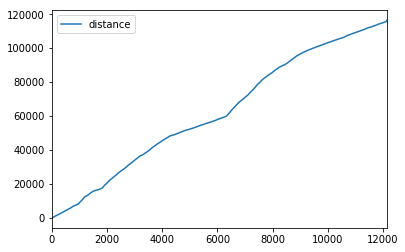

In [10]:
s[['distance']].plot()

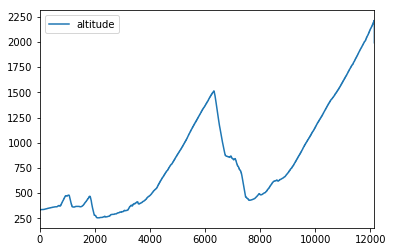

In [11]:
# Plot altitude vs time
s[['altitude']].plot()

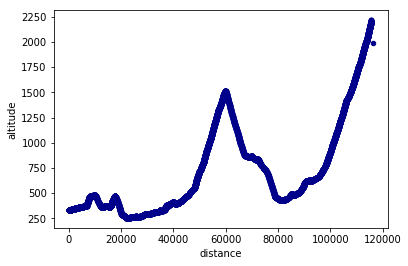

In [12]:
#plot altitude vs distance - explain the differences with the previous plot
s.plot.scatter(x='distance',y='altitude',c='DarkBlue')

## Visualizing using Plotly and Plotly Express

Plotly is a well known open source library for visualization that can used quite easily in notebooks such as this one. In the Spring of 2019, Plotly Express [was announced](https://medium.com/plotly/introducing-plotly-express-808df010143d) -   a terse, consistent, high-level API for rapid data exploration and figure generation (in other words: many of the visualizations required can be created with Plotly Express (while leveraging all of Plotly) in just a few lines of code).

In this notebook, I am using Plotly 4.1 (https://plot.ly/python/getting-started/) - which by default is off line and includes plotly express.

If you do no know Plotly yet, please read [this article](https://towardsdatascience.com/the-next-level-of-data-visualization-in-python-dd6e99039d5e) by Will Koehrsen who declares his love for Plotly in a moving and convincing way.

In [13]:
# Using Conda for the installation:
# conda install -c plotly plotly=4.1.0
# conda install -c plotly chart-studio=1.0.0

# Next, these imports and initializations are required to load plotly and cufflinks and to use plotly locally.

import plotly.graph_objs as go
import plotly.express as px
from chart_studio.plotly import plot, iplot

Create an interactive Plotly chart (you can hover, zoom, pan) that shows distance as a function of time. This shows the distance Steven Kruijswijk covered as Stage 14 progressed. Steepness of the curve is indicative of speed - and indirectly of gradient I presume.

In [16]:
fig = px.line(s, x="time", y="distance", title='Distance vs Time for Steven Kruijswijk in Stage 14 of Tour de France 2019', render_mode='svg')
fig.show()

# In my environment, Plotly Express seems to only render datasets of maximum 1000 records; the figure does not show data point if the data set is larger than 1000 points
# that is: above 1000 points, render mode switches to webgl; currently webgl rendering does not work correctly on my laptop for some reason
# to work around this problem, I have explicitly set render_mode to svg; you may not have to do that in your environment

In [13]:
# Without Plotly Express, the previous chart would be created as follows
fig = go.Figure()
fig.add_trace(go.Scatter(x=s['time'], y=s['distance'], mode='lines', line=dict(color='red', width=1), name='Steven'))
fig.update_layout(title='Distance vs Time for Steven Kruijswijk')
fig.show()

The next plot shows a scatter plot that at least suggests an unsurprising relationship between gradient (steepness) and speed. Note that there a few outliers - incorrect read outs from whatever device Kruijswijk was using to record his data.

In [14]:
fig = px.scatter(s, x="grade_smooth", y="speed", render_mode='svg',labels={'grade_smooth':'gradient'}, title="Speed vs Gradient for Steven Kruijswijk")
fig.show()

Create an interactive plotly chart that shows both speed and altitude as a function of distance. This brings out the altitude contours for the stage (see that Col du Tourmalet) and shows the speed as Steven rides up and down the mountains.

In [19]:
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=s['distance'],
        y=s['speed'],
        mode="lines",
        line=go.scatter.Line(color="red"), name='speed')
    , secondary_y=False
)
        
fig.add_trace(
    go.Scatter(
        x=s['distance'],
        y=s['altitude'],
        mode="lines",
        line=go.scatter.Line(color="black", dash="dot"), name='Altitude')
    , secondary_y=True
)

# Set x-axis title
fig.update_xaxes(title_text="Distance from Départ")

# Set y-axes titles
fig.update_yaxes(title_text="Speed in KM/H", secondary_y=False)
fig.update_yaxes(title_text="Altitude in meters", secondary_y=True)
fig.show()


# Resources
Article on mining Strava Data, explicitly discussing segment data for the Col du Tourmalet: http://olivernash.org/2014/05/25/mining-the-strava-data/ 

Report on the 14th Stage in the Tour de France of 2019: https://www.letour.fr/en/news/2019/stage-14/thibaut-pinot-takes-revenge-for-crosswinds-disaster/1280846 . Another report: http://www.cyclingnews.com/tour-de-france/stage-14/results/ with the story of the stage, including summary of breakaways and the extended neutralised section of the stage. As a result - the actual race was 109 km in length. And: the at the time live blog for The Guardian: https://www.theguardian.com/sport/live/2019/jul/20/tour-de-france-2019-stage-14-takes-race-up-to-finish-on-tourmalet-live.  

Online JSON Editor - convenient for quickly checking on JSON data copied/pasted from Strava - https://jsoneditoronline.org/ 

Introduction to Interactive Time Series Visualizations with Plotly in Python by Will Koehrsen - https://towardsdatascience.com/introduction-to-interactive-time-series-visualizations-with-plotly-in-python-d3219eb7a7af

Installing plotly (4.1): see: https://plot.ly/python/getting-started/
Introducing Plotly Express: https://medium.com/plotly/introducing-plotly-express-808df010143d 

Plotly Reference on Axes, Annotations, Shapes etc: https://plot.ly/python/reference/#layout-xaxis 

# Technical Environment
For this notebook, I made use of Jupyter Notebook 5.7 with the Jupyter Lab extension 1.0.4 installed (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) in combination with ploty 4.1

conda install -c conda-forge jupyterlab

Installing plotly (4.1): 

conda install -c plotly plotly=4.1.0 

conda install -c plotly chart-studio=1.0.0

conda install jupyterlab=1.0 "ipywidgets>=7.5"

(see: https://plot.ly/python/getting-started/)

